<font color=green>Wang, Wei, et al. "End-to-end encrypted traffic classification with one-dimensional convolution neural networks." 2017 IEEE International Conference on Intelligence and Security Informatics (ISI). IEEE, 2017.</font>

### 处理Pcap工具： SplitCap2.1; finddupe; 

### 数据集格式：mnist （784 * 1）

### ① 1D CNN比 2D效果好
### ② 二分类达 100%
### ③ 12分类达 96%
### ④ 6分类，VPN 97%； NoVPN 94%

## <font color= blue>以下代码仅复现 SessionAllLayers </font>

In [1]:
import pandas as pd
import os
import tensorflow as tf
import time
import numpy as np
from tensorflow.examples import input_data
import matplotlib.pyplot as plt
from sklearn import metrics

In [47]:
dir_2class_ALL = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionAllLayers'
dir_12class_ALL = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionAllLayers'
dir_6class_Vpn_ALL = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionAllLayers'
dir_6class_NoVpn_ALL = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionAllLayers'

dir_2class_L7 = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionL7'
dir_12class_L7 = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionL7'
dir_6class_NoVpn_L7 = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionL7'
dir_6class_Vpn_L7 = r'H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionL7'

In [3]:
dict_2class = {0:'Novpn',1:'Vpn'}

# <font color=Red>二分类 ACC,REC:100%</font>

In [4]:
mnist = input_data.read_data_sets(dir_2class_ALL)

Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionAllLayers\train-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionAllLayers\train-labels-idx1-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionAllLayers\t10k-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\2class\SessionAllLayers\t10k-labels-idx1-ubyte.gz


In [5]:
dir(mnist)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'test',
 'train',
 'validation']

In [6]:
dir(mnist.train)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_epochs_completed',
 '_images',
 '_index_in_epoch',
 '_labels',
 '_num_examples',
 'epochs_completed',
 'images',
 'labels',
 'next_batch',
 'num_examples']

In [7]:
print('train:',mnist.train.num_examples)
print('test:',mnist.test.num_examples)
print('validation:',mnist.validation.num_examples)

train: 30501
test: 3945
validation: 5000


## <font color=red>2D可视化</font>

### 制作mnist时，使用imload()函数，自动resize为【0,1】的double；
### mnist.train.images为55000个长度为784的list元组（1D）；2D可视化需要reshape；

In [8]:
len(mnist.train.images[1])

784

In [9]:
tmp_train = np.reshape(mnist.train.images,(-1,28,28))
tmp_train = np.expand_dims(tmp_train,axis=-1)

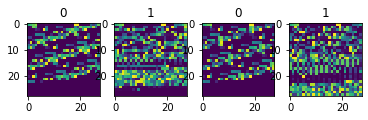

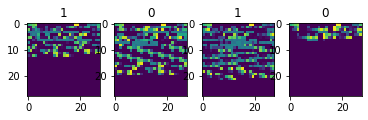

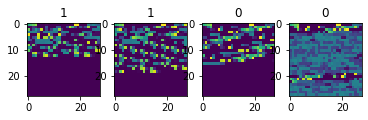

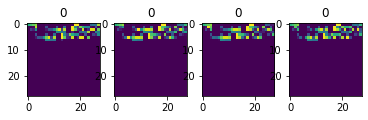

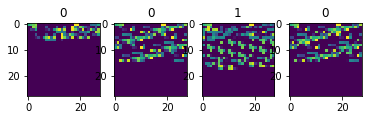

In [10]:
for k in range(5):
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(mnist.train.labels[k*4+i])
        axs[i].imshow(tmp_train[k*4+i,:,:,0])
    plt.show()

## 预处理

In [11]:
train_1d = np.expand_dims(mnist.train.images,axis=-1)
test_1d = np.expand_dims(mnist.test.images,axis=-1)
validation_1d = np.expand_dims(mnist.validation.images,axis=-1)

# <font color=red>CNN （1D）</font>

In [12]:
class CNN_1d():
    def __init__(self,filters=32,kernel_size=2):
        self.filters = filters
        self.kernel_size = kernel_size
    
    def model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    padding='same',
                    activation=tf.nn.relu,
                    input_shape=(784,1)
                ),
            tf.keras.layers.MaxPool1D(pool_size=2),
            tf.keras.layers.Conv1D(
                    filters=64,
                    kernel_size=self.kernel_size,
                    padding='same',
                    activation=tf.nn.relu
                ),
            tf.keras.layers.MaxPool1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units=2, activation='softmax')
        ])
        model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        return model

In [13]:
CNN = CNN_1d(32,2).model()

In [14]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 784, 32)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 392, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 392, 64)           4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 196, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              12846080  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [15]:
CNN_history = CNN.fit(train_1d,
                      mnist.train.labels,
                      epochs = 30,
                      batch_size=512,
                      validation_data = (validation_1d,mnist.validation.labels)
                     )

Train on 30501 samples, validate on 5000 samples
Epoch 1/30
30501/30501 [==============================] - 22s 736us/sample - loss: 0.0772 - accuracy: 0.9634 - val_loss: 0.0054 - val_accuracy: 0.9986
Epoch 2/30
30501/30501 [==============================] - 11s 370us/sample - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 3/30
30501/30501 [==============================] - 12s 378us/sample - loss: 0.0013 - accuracy: 0.9998 - val_loss: 5.3259e-04 - val_accuracy: 1.0000
Epoch 4/30
30501/30501 [==============================] - 12s 386us/sample - loss: 4.9782e-04 - accuracy: 1.0000 - val_loss: 3.6680e-04 - val_accuracy: 1.0000
Epoch 5/30
30501/30501 [==============================] - 12s 390us/sample - loss: 3.7880e-04 - accuracy: 1.0000 - val_loss: 3.0421e-04 - val_accuracy: 1.0000
Epoch 6/30
30501/30501 [==============================] - 12s 382us/sample - loss: 1.7458e-04 - accuracy: 1.0000 - val_loss: 1.5972e-04 - val_accuracy: 1.0000
Epoch 7/30
30501/

In [16]:
pre = CNN.predict(test_1d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist.test.labels, pre))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2692
           1       1.00      1.00      1.00      1253

    accuracy                           1.00      3945
   macro avg       1.00      1.00      1.00      3945
weighted avg       1.00      1.00      1.00      3945



# <font color=red>12分类  96%</font>

In [17]:
mnist_12 = input_data.read_data_sets(dir_12class_ALL)

Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionAllLayers\train-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionAllLayers\train-labels-idx1-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionAllLayers\t10k-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\12class\SessionAllLayers\t10k-labels-idx1-ubyte.gz


In [18]:
print('train:',mnist_12.train.num_examples)
print('test:',mnist_12.test.num_examples)
print('validation:',mnist_12.validation.num_examples)

train: 30501
test: 3945
validation: 5000


In [19]:
dict_12class = {0:'Chat',1:'Email',2:'File',3:'P2p',4:'Streaming',5:'Voip',6:'Vpn_Chat',7:'Vpn_Email',8:'Vpn_File',9:'Vpn_P2p',10:'Vpn_Streaming',11:'Vpn_Voip'}

In [20]:
from collections import Counter
Counter(mnist_12.train.labels)

Counter({2: 4625,
         5: 4639,
         11: 4656,
         0: 4657,
         1: 4678,
         6: 3143,
         8: 769,
         7: 223,
         4: 1449,
         10: 496,
         3: 796,
         9: 370})

## 2D可视化

In [21]:
tmp_train = np.reshape(mnist_12.train.images,(-1,28,28))
tmp_train = np.expand_dims(tmp_train,axis=-1)

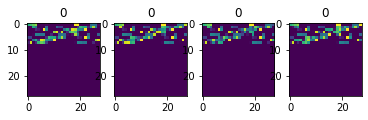

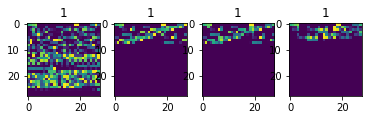

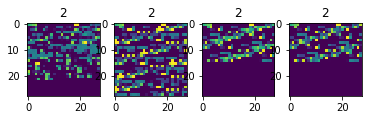

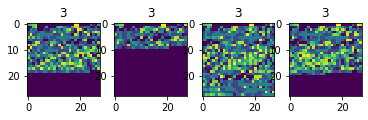

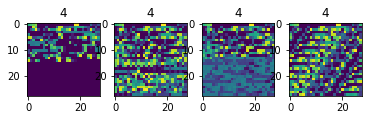

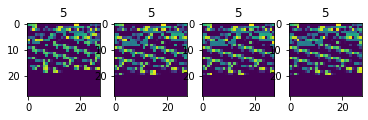

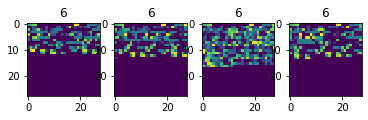

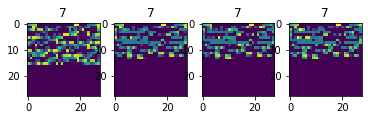

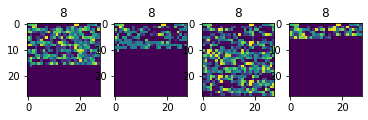

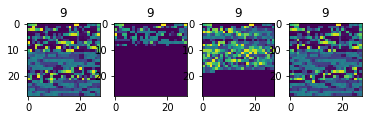

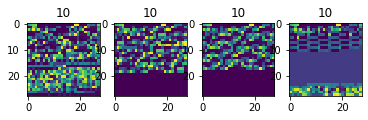

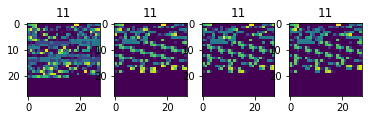

In [22]:
tmp = {}
for i in range(12):
    tmp[i] = []

for i,d in enumerate(mnist_12.train.labels):
    if len(tmp[d]) < 4:
        tmp[d].append(i)
    c = 0 #满4个的数量
    for i in tmp:
        if len(tmp[i]) == 4:
            c += 1
    if c >=12:
        break

for d in range(12):
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(d)
        axs[i].imshow(tmp_train[tmp[d][i],:,:,0])
    plt.show()

In [23]:
train_12_1d = np.expand_dims(mnist_12.train.images,axis=-1)
test_12_1d = np.expand_dims(mnist_12.test.images,axis=-1)
validation_12_1d = np.expand_dims(mnist_12.validation.images,axis=-1)

In [24]:
def CNN_12():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu,
                input_shape=(784,1)
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=12, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [25]:
cnn_12 = CNN_12()
cnn_12.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 784, 32)           96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 392, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 392, 64)           4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 196, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              12846080  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

In [26]:
cnn_12_history = cnn_12.fit(train_12_1d,
                      mnist_12.train.labels,
                      epochs = 50,
                      batch_size=512,
                      validation_data = (validation_12_1d,mnist_12.validation.labels)
                     )

Train on 30501 samples, validate on 5000 samples
Epoch 1/100
30501/30501 [==============================] - 12s 389us/sample - loss: 0.7131 - accuracy: 0.7256 - val_loss: 0.4334 - val_accuracy: 0.7958
Epoch 2/100
30501/30501 [==============================] - 12s 385us/sample - loss: 0.3895 - accuracy: 0.8201 - val_loss: 0.3511 - val_accuracy: 0.8218
Epoch 3/100
30501/30501 [==============================] - 12s 378us/sample - loss: 0.3121 - accuracy: 0.8482 - val_loss: 0.3288 - val_accuracy: 0.8430
Epoch 4/100
30501/30501 [==============================] - 12s 381us/sample - loss: 0.2737 - accuracy: 0.8613 - val_loss: 0.2860 - val_accuracy: 0.8526
Epoch 5/100
30501/30501 [==============================] - 12s 387us/sample - loss: 0.2481 - accuracy: 0.8702 - val_loss: 0.2744 - val_accuracy: 0.8612
Epoch 6/100
30501/30501 [==============================] - 12s 390us/sample - loss: 0.2283 - accuracy: 0.8766 - val_loss: 0.2631 - val_accuracy: 0.8660
Epoch 7/100
30501/30501 [==============

30501/30501 [==============================] - 12s 391us/sample - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.1707 - val_accuracy: 0.9548
Epoch 55/100
30501/30501 [==============================] - 12s 395us/sample - loss: 0.0195 - accuracy: 0.9920 - val_loss: 0.1729 - val_accuracy: 0.9558- loss: 0.0191 - 
Epoch 56/100
30501/30501 [==============================] - 12s 394us/sample - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.1659 - val_accuracy: 0.9568
Epoch 57/100
30501/30501 [==============================] - 12s 394us/sample - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.1828 - val_accuracy: 0.9546
Epoch 58/100
30501/30501 [==============================] - 12s 395us/sample - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.1683 - val_accuracy: 0.9590
Epoch 59/100
30501/30501 [==============================] - 12s 391us/sample - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.1672 - val_accuracy: 0.9592
Epoch 60/100
30501/30501 [==============================] - 12s 389us/sample -

Text(0.5, 1.0, 'Accuracy Curves')

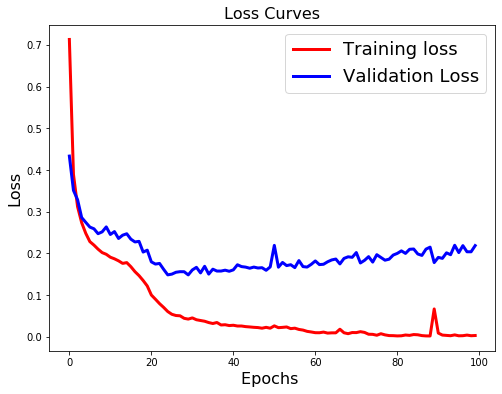

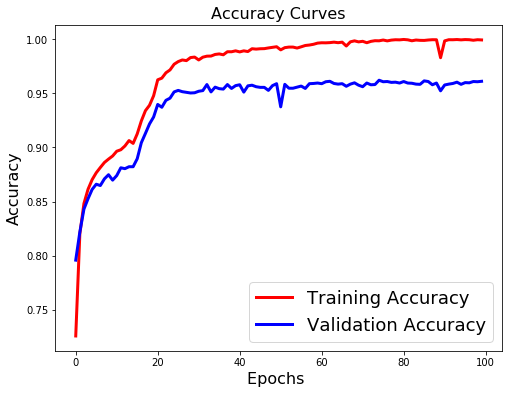

In [27]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_12_history.history['loss'],'r',linewidth=3.0)
plt.plot(cnn_12_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_12_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(cnn_12_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [28]:
pre = cnn_12.predict(test_12_1d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist_12.test.labels, pre))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       600
           1       0.99      0.98      0.98       600
           2       0.90      0.91      0.90       600
           3       1.00      0.98      0.99       104
           4       0.98      0.97      0.98       188
           5       0.91      0.91      0.91       600
           6       0.98      0.99      0.99       407
           7       0.93      0.93      0.93        30
           8       0.94      0.96      0.95       102
           9       1.00      0.94      0.97        48
          10       1.00      0.97      0.98        66
          11       0.99      0.99      0.99       600

    accuracy                           0.96      3945
   macro avg       0.97      0.96      0.96      3945
weighted avg       0.96      0.96      0.96      3945



# <font color=red>12分类 2D  92%</font>

In [29]:
train_12_2d = np.reshape(mnist_12.train.images,(-1,28,28))
train_12_2d = np.expand_dims(train_12_2d,axis=-1)

test_12_2d = np.reshape(mnist_12.test.images,(-1,28,28))
test_12_2d = np.expand_dims(test_12_2d,axis=-1)

validation_12_2d = np.reshape(mnist_12.validation.images,(-1,28,28))
validation_12_2d = np.expand_dims(validation_12_2d,axis=-1)

In [38]:
def CNN_12_2d():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=[3,3],
                padding='same',
                activation=tf.nn.relu,
                input_shape=(28,28,1)
            ),
        tf.keras.layers.MaxPool2D(pool_size=[2,2]),
        tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=[3,3],
                padding='same',
                activation=tf.nn.relu
            ),
        tf.keras.layers.MaxPool2D(pool_size=[2,2]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=12, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [39]:
cnn_12_2d = CNN_12_2d()
cnn_12_2d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              3212288   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)             

In [43]:
cnn_12_2d_history = cnn_12_2d.fit(train_12_2d,
                      mnist_12.train.labels,
                      epochs = 50,
                      batch_size=512,
                      validation_data = (validation_12_2d,mnist_12.validation.labels)
                     )

Train on 30501 samples, validate on 5000 samples
Epoch 1/50
30501/30501 [==============================] - 7s 222us/sample - loss: 0.9362 - accuracy: 0.6670 - val_loss: 0.5776 - val_accuracy: 0.7510
Epoch 2/50
30501/30501 [==============================] - 5s 163us/sample - loss: 0.4928 - accuracy: 0.7794 - val_loss: 0.4406 - val_accuracy: 0.8038
Epoch 3/50
30501/30501 [==============================] - 5s 165us/sample - loss: 0.3954 - accuracy: 0.8166 - val_loss: 0.3927 - val_accuracy: 0.8156
Epoch 4/50
30501/30501 [==============================] - 5s 166us/sample - loss: 0.3473 - accuracy: 0.8343 - val_loss: 0.3484 - val_accuracy: 0.8330
Epoch 5/50
30501/30501 [==============================] - 5s 170us/sample - loss: 0.3097 - accuracy: 0.8485 - val_loss: 0.3364 - val_accuracy: 0.8368
Epoch 6/50
30501/30501 [==============================] - 5s 167us/sample - loss: 0.2904 - accuracy: 0.8549 - val_loss: 0.3177 - val_accuracy: 0.8256
Epoch 7/50
30501/30501 [===========================

Text(0.5, 1.0, 'Accuracy Curves')

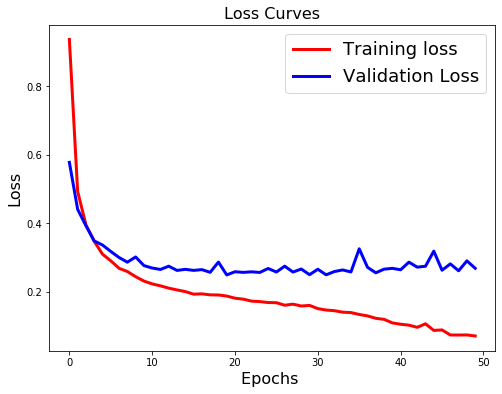

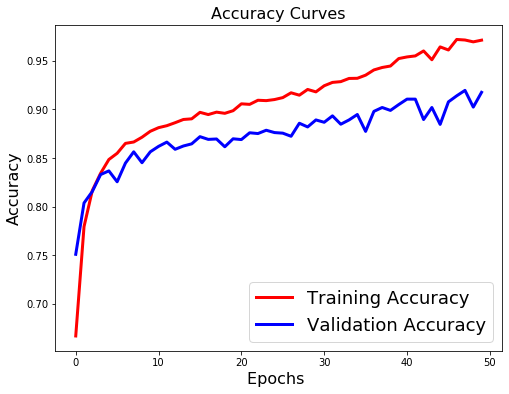

In [44]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_12_2d_history.history['loss'],'r',linewidth=3.0)
plt.plot(cnn_12_2d_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_12_2d_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(cnn_12_2d_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [46]:
pre = cnn_12_2d.predict(test_12_2d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist_12.test.labels, pre))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       600
           1       0.88      0.87      0.88       600
           2       0.90      0.88      0.89       600
           3       1.00      0.95      0.98       104
           4       0.95      0.98      0.97       188
           5       0.89      0.89      0.89       600
           6       0.99      1.00      0.99       407
           7       0.97      0.93      0.95        30
           8       0.99      0.94      0.96       102
           9       1.00      0.94      0.97        48
          10       0.95      0.95      0.95        66
          11       1.00      0.99      0.99       600

    accuracy                           0.92      3945
   macro avg       0.95      0.94      0.94      3945
weighted avg       0.92      0.92      0.92      3945



# <font color=red>6分类 1D  </font>

In [48]:
dict_6class_novpn = {0:'Chat',1:'Email',2:'File',3:'P2p',4:'Streaming',5:'Voip'}
dict_6class_vpn = {0:'Vpn_Chat',1:'Vpn_Email',2:'Vpn_File',3:'Vpn_P2p',4:'Vpn_Streaming',5:'Vpn_Voip'}

## VPN 97%

In [49]:
mnist_6Vpn = input_data.read_data_sets(dir_6class_Vpn_ALL)
print('train:',mnist_6Vpn.train.num_examples)
print('test:',mnist_6Vpn.test.num_examples)
print('validation:',mnist_6Vpn.validation.num_examples)

Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionAllLayers\train-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionAllLayers\train-labels-idx1-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionAllLayers\t10k-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\VpnSessionAllLayers\t10k-labels-idx1-ubyte.gz
train: 6272
test: 1253
validation: 5000


In [50]:
from collections import Counter
Counter(mnist_6Vpn.train.labels)

Counter({0: 2046, 1: 142, 5: 2981, 2: 525, 4: 343, 3: 235})

In [51]:
train_6Vpn_1d = np.expand_dims(mnist_6Vpn.train.images,axis=-1)
test_6Vpn_1d = np.expand_dims(mnist_6Vpn.test.images,axis=-1)
validation_6Vpn_1d = np.expand_dims(mnist_6Vpn.validation.images,axis=-1)

In [52]:
def CNN_6Vpn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu,
                input_shape=(784,1)
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=6, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [54]:
cnn_6vpn = CNN_6Vpn()
cnn_6vpn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 784, 32)           96        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 392, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 392, 64)           4160      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 196, 64)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              12846080  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)             

In [55]:
cnn_6vpn_history = cnn_6vpn.fit(train_6Vpn_1d,
                      mnist_6Vpn.train.labels,
                      epochs = 50,
                      batch_size=512,
                      validation_data = (validation_6Vpn_1d,mnist_6Vpn.validation.labels)
                     )

Train on 6272 samples, validate on 5000 samples
Epoch 1/50
6272/6272 [==============================] - 5s 756us/sample - loss: 0.8750 - accuracy: 0.6910 - val_loss: 0.5381 - val_accuracy: 0.8090
Epoch 2/50
6272/6272 [==============================] - 3s 458us/sample - loss: 0.4695 - accuracy: 0.8347 - val_loss: 0.3906 - val_accuracy: 0.8624
Epoch 3/50
6272/6272 [==============================] - 3s 458us/sample - loss: 0.3251 - accuracy: 0.8940 - val_loss: 0.2884 - val_accuracy: 0.9030
Epoch 4/50
6272/6272 [==============================] - 3s 463us/sample - loss: 0.2314 - accuracy: 0.9259 - val_loss: 0.2210 - val_accuracy: 0.9236
Epoch 5/50
6272/6272 [==============================] - 3s 463us/sample - loss: 0.1727 - accuracy: 0.9452 - val_loss: 0.2044 - val_accuracy: 0.9286
Epoch 6/50
6272/6272 [==============================] - 3s 470us/sample - loss: 0.1300 - accuracy: 0.9614 - val_loss: 0.1627 - val_accuracy: 0.9484
Epoch 7/50
6272/6272 [==============================] - 3s 468us

Text(0.5, 1.0, 'Accuracy Curves')

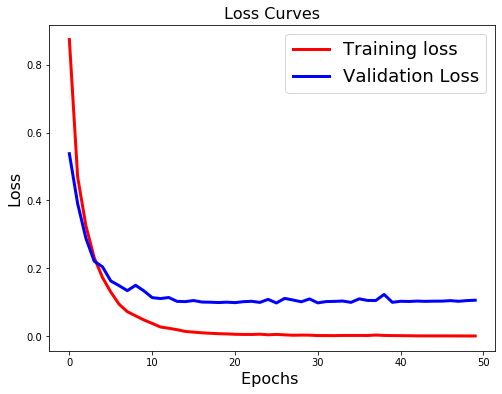

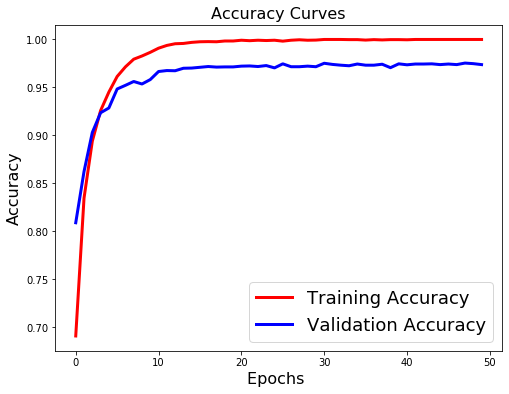

In [56]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_6vpn_history.history['loss'],'r',linewidth=3.0)
plt.plot(cnn_6vpn_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(cnn_6vpn_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(cnn_6vpn_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [57]:
pre = cnn_6vpn.predict(test_6Vpn_1d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist_6Vpn.test.labels, pre))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       407
           1       1.00      0.93      0.97        30
           2       0.91      0.89      0.90       102
           3       1.00      0.92      0.96        48
           4       0.89      0.97      0.93        66
           5       0.99      0.99      0.99       600

    accuracy                           0.97      1253
   macro avg       0.96      0.95      0.95      1253
weighted avg       0.97      0.97      0.97      1253



# NoVpn 94%

In [58]:
mnist_6NoVpn = input_data.read_data_sets(dir_6class_NoVpn_ALL)
print('train:',mnist_6NoVpn.train.num_examples)
print('test:',mnist_6NoVpn.test.num_examples)
print('validation:',mnist_6NoVpn.validation.num_examples)

Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionAllLayers\train-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionAllLayers\train-labels-idx1-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionAllLayers\t10k-images-idx3-ubyte.gz
Extracting H:\VPN-nonVPN(ISCXVPN2016)\pcaps\3.PerprocessResults\6class\NoVpnSessionAllLayers\t10k-labels-idx1-ubyte.gz
train: 19229
test: 2692
validation: 5000


In [59]:
Counter(mnist_6NoVpn.train.labels)

Counter({1: 4260, 5: 4273, 2: 4305, 0: 4318, 3: 747, 4: 1326})

In [60]:
train_6NoVpn_1d = np.expand_dims(mnist_6NoVpn.train.images,axis=-1)
test_6NoVpn_1d = np.expand_dims(mnist_6NoVpn.test.images,axis=-1)
validation_6NoVpn_1d = np.expand_dims(mnist_6NoVpn.validation.images,axis=-1)

In [61]:
def CNN_6NoVpn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu,
                input_shape=(784,1)
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                padding='same',
                activation=tf.nn.relu
            ),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=6, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [62]:
cnn_6NoVpn = CNN_6NoVpn()
cnn_6NoVpn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 784, 32)           96        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 392, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 392, 64)           4160      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 196, 64)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              12846080  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)             

In [63]:
cnn_6NoVpn_history = cnn_6NoVpn.fit(train_6NoVpn_1d,
                      mnist_6NoVpn.train.labels,
                      epochs = 50,
                      batch_size=512,
                      validation_data = (validation_6NoVpn_1d,mnist_6NoVpn.validation.labels)
                     )

Train on 19229 samples, validate on 5000 samples
Epoch 1/50
19229/19229 [==============================] - 8s 421us/sample - loss: 0.7876 - accuracy: 0.6401 - val_loss: 0.5410 - val_accuracy: 0.7472
Epoch 2/50
19229/19229 [==============================] - 7s 387us/sample - loss: 0.4819 - accuracy: 0.7641 - val_loss: 0.4561 - val_accuracy: 0.7712
Epoch 3/50
19229/19229 [==============================] - 8s 391us/sample - loss: 0.4174 - accuracy: 0.7854 - val_loss: 0.4369 - val_accuracy: 0.7762
Epoch 4/50
19229/19229 [==============================] - 8s 396us/sample - loss: 0.3918 - accuracy: 0.7956 - val_loss: 0.4080 - val_accuracy: 0.7836
Epoch 5/50
19229/19229 [==============================] - 8s 393us/sample - loss: 0.3681 - accuracy: 0.8012 - val_loss: 0.3906 - val_accuracy: 0.7972
Epoch 6/50
19229/19229 [==============================] - 8s 394us/sample - loss: 0.3498 - accuracy: 0.8126 - val_loss: 0.3887 - val_accuracy: 0.7862
Epoch 7/50
19229/19229 [===========================

In [64]:
pre = cnn_6NoVpn.predict(test_6NoVpn_1d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist_6NoVpn.test.labels, pre))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       600
           1       0.97      0.96      0.97       600
           2       0.88      0.91      0.90       600
           3       0.97      1.00      0.99       104
           4       0.98      0.97      0.97       188
           5       0.90      0.89      0.90       600

    accuracy                           0.94      2692
   macro avg       0.95      0.95      0.95      2692
weighted avg       0.94      0.94      0.94      2692



# <font color=red>6分类 2D 89% </font>

In [65]:
train_6NoVpn_2d = np.reshape(mnist_6NoVpn.train.images,(-1,28,28))
train_6NoVpn_2d = np.expand_dims(train_6NoVpn_2d,axis=-1)

test_6NoVpn_2d = np.reshape(mnist_6NoVpn.test.images,(-1,28,28))
test_6NoVpn_2d = np.expand_dims(test_6NoVpn_2d,axis=-1)

validation_6NoVpn_2d = np.reshape(mnist_6NoVpn.validation.images,(-1,28,28))
validation_6NoVpn_2d = np.expand_dims(validation_6NoVpn_2d,axis=-1)

In [68]:
def CNN_6NoVpn_2d():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=[3,3],
                padding='same',
                activation=tf.nn.relu,
                input_shape=(28,28,1)
            ),
        tf.keras.layers.MaxPool2D(pool_size=[2,2]),
        tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=[3,3],
                padding='same',
                activation=tf.nn.relu
            ),
        tf.keras.layers.MaxPool2D(pool_size=[2,2]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=6, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [69]:
cnn_6NoVpn_2d = CNN_6NoVpn_2d()
cnn_6NoVpn_2d.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              3212288   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)            

In [70]:
cnn_6NoVpn_2d_history = cnn_6NoVpn_2d.fit(train_6NoVpn_2d,
                      mnist_6NoVpn.train.labels,
                      epochs = 50,
                      batch_size=512,
                      validation_data = (validation_6NoVpn_2d,mnist_6NoVpn.validation.labels)
                     )

Train on 19229 samples, validate on 5000 samples
Epoch 1/50
19229/19229 [==============================] - 4s 201us/sample - loss: 0.8695 - accuracy: 0.6205 - val_loss: 0.6342 - val_accuracy: 0.7220
Epoch 2/50
19229/19229 [==============================] - 3s 167us/sample - loss: 0.5770 - accuracy: 0.7269 - val_loss: 0.5190 - val_accuracy: 0.7446
Epoch 3/50
19229/19229 [==============================] - 3s 168us/sample - loss: 0.4878 - accuracy: 0.7598 - val_loss: 0.4703 - val_accuracy: 0.7734
Epoch 4/50
19229/19229 [==============================] - 3s 171us/sample - loss: 0.4372 - accuracy: 0.7817 - val_loss: 0.4407 - val_accuracy: 0.7830
Epoch 5/50
19229/19229 [==============================] - 3s 172us/sample - loss: 0.4162 - accuracy: 0.7893 - val_loss: 0.4297 - val_accuracy: 0.7822
Epoch 6/50
19229/19229 [==============================] - 3s 171us/sample - loss: 0.3958 - accuracy: 0.7959 - val_loss: 0.4052 - val_accuracy: 0.7900
Epoch 7/50
19229/19229 [===========================

In [71]:
pre = cnn_12_2d.predict(test_6NoVpn_2d)
pre = np.argmax(pre, axis=1)
print(metrics.classification_report(mnist_6NoVpn.test.labels, pre))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       600
           1       0.89      0.87      0.88       600
           2       0.90      0.88      0.89       600
           3       1.00      0.95      0.98       104
           4       0.95      0.98      0.97       188
           5       0.89      0.89      0.89       600

    accuracy                           0.89      2692
   macro avg       0.91      0.91      0.91      2692
weighted avg       0.89      0.89      0.89      2692

